参数与变量的区别: 参数用来传递并且可以优化，变量是随着过程的赋值改变的

In [6]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
# import talib as ta
import numpy as np

########################################################################
# 策略继承CtaTemplate
class RBreaker(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'RBreaker'
    author = 'Qi Luo'
    
    print('instrategyclass')
    
    # 策略参数
    fastPeriod = 20     # 快速均线参数
    slowPeriod = 55    # 慢速均线参数
    lot = 1             # 设置手数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    pricelist = []
#     am1d = None

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
#         self.flag = False
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.generateBarDict(self.onBar, size = 5)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    def on1DBar(self, bar):
        print('1dbar')
        
#         self.flag = False
        symbol = bar.vtSymbol
        
        self.am1d = self.getArrayManager(symbol, "1d") # 获取历史数组
        
        self.pricelist = []
    
    #----------------------------------------------------------------------
    def on10minBar(self, bar):
#         print('inbar')
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "10min") # 获取历史数组
        
#         if not am.inited:
#             print('return not inited')
#             return
        
#         # 计算策略需要的信号-------------------------------------------------
#         fastMa = ta.EMA(am60.close, self.fastPeriod)
#         slowMa = ta.EMA(am60.close, self.slowPeriod)
        
#         crossOver = (fastMa[-1]>slowMa[-1]) and (fastMa[-2]<=slowMa[-2]) # 金叉上穿 
#         crossBelow = (fastMa[-1]<slowMa[-1]) and (fastMa[-2]>=slowMa[-2]) # 死叉下穿

        
#         # 构建进出场逻辑-------------------------------------------------
#         # 如果金叉时手头没有多头持仓
#         if (crossOver) and (self.posDict[symbol+'_LONG']==0):
#             # 如果没有空头持仓，则直接做多
#             if  self.posDict[symbol+'_SHORT']==0:
#                 self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
#             # 如果有空头持仓，则先平空，再做多
#             elif self.posDict[symbol+'_SHORT'] > 0:
#                 self.cancelAll() # 撤销挂单
#                 print('平空',self.posDict[symbol+'_SHORT'])
#                 self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
#                 self.buy(symbol, bar.close*1.01, self.lot)
#         # 如果死叉时手头没有空头持仓
#         elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
#             if self.posDict[symbol+'_LONG']==0:
#                 self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
#             elif self.posDict[symbol+'_LONG'] > 0:
#                 self.cancelAll() # 撤销挂单
#                 print('平空',self.posDict[symbol+'_LONG'])
#                 self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
#                 self.short(symbol, bar.close*0.99, self.lot)
        
        
        #context.counter += 1
        #i = context.counter
        qty_b = self.posDict[symbol+'_LONG']#买方向持仓
        qty_s = self.posDict[symbol+'_SHORT']#卖方向持仓
        #logger.info(qty_b)
        #logger.info(qty_s)
#         if bar.time.hour < 15:
#             print('in')
        self.am1d = self.getArrayManager(symbol, "1d")
#         print(bar.date, self.am1d.close[-10:])
        Close = self.am1d.close[-1] #导出前日收盘价
        Open = self.am1d.open[-1]#导出前日开盘价
        High = self.am1d.high[-1]#导出前日最高价
        Low = self.am1d.low[-1]#导出前日最低价
#         print('close, open, high, low',bar.date, Close, Open, High, Low)
    #根据python数组定义，high[0]在此表示昨日最高价，以此类推
        pivot=np.mean([High,Low,Close])
        Bsetup=Low-0.8*(High-Close)#观察买入价
        Ssetup=High+0.8*(Close-Low)#观察卖出价
        Benter=(1.07/2)*(High+Low)-0.07*High#反转买入价
        Senter=(1.07/2)*(High+Low)-0.07*Low #反转卖出价
        Bbreak=Ssetup+0.03*(Ssetup-Bsetup)#突破买入价
        Sbreak=Bsetup-0.03*(Ssetup-Bsetup) #突破卖出价
    #print(High[0])
        prices = bar.close#获取日内盘中价格
        self.pricelist.append(prices)
        day_high=max(self.pricelist)

        day_low=min(self.pricelist)
        '''
        logger.info(prices)
        logger.info(High[0])
        logger.info(Ssetup)
        logger.info(high)
        logger.info(Bbreak)
        '''
        con= (float(qty_s) <=0) & (float(qty_b) <= 0)
#         print(bar.date, bar.time,self.flag)
        if prices > Bbreak and qty_b == 0 and qty_s == 0:          #盘中价格超过突破买入价，做多
#                 buy_open(context.s1,1)
            self.buy(symbol, bar.close*1.01, self.lot)
            self.flag = True
            print(bar.date, bar.time, '空仓做多')

        elif prices < Sbreak and qty_b == 0 and qty_s == 0:          #盘中价格跌过突破卖出价，做空
#                 sell_open(context.s1,1)
            self.short(symbol, bar.close*0.99, self.lot)
            self.flag = False

            print(bar.date, bar.time,'空仓做空')
        elif day_high > Ssetup and Senter > prices and qty_b > 0:#持多单，当日内最高价超过观察卖出价(Ssetup)后，盘中价格出现回落，且进一步跌破反转卖出价（Senter）构成的支撑线时，采取反转策略，即在该点位反手做空；
#                 sell_open(context.s1,1)#卖出开仓
#                 sell_close(context.s1,qty_b)#平多仓
            self.cancelAll()
            self.short(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

            self.short(symbol, bar.close*0.99, self.lot)
            self.flag = True

            print(bar.date, bar.time,'多单做空')

        elif day_low < Bsetup and prices> Benter and qty_s >0:#持空单，当日内最低价低于观察买入价(Bsetup）后，盘中价格出现反弹，且进一步超过反转买入价(Benter)构成的阻力线时，采取反转策略，即在该点位反手做多；
#                 buy_open(context.s1,1)
#                 buy_close(context.s1,qty_s)
            self.cancelAll()
            self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

            self.buy(symbol, bar.close*1.01, self.lot)
            self.flag = True

            print(bar.date, bar.time,'空单做多')
#         elif int(str(context.now.hour)) == 15:
#             close(context)       
#         if context.portfolio.daily_returns < -0.05:
#             close(context)
#             logger.info('止损')
        buyStopLossPrice = self.transactionPrice[symbol] * (1 - 0.05)
        sellStopLossPrice = self.transactionPrice[symbol] * (1 + 0.03)
        if (self.posDict[symbol + '_LONG'] > 0):
            if (bar.close <= buyStopLossPrice):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + '_LONG'])
                print(bar.date, bar.time,'止损')
        elif (self.posDict[symbol + '_SHORT'] > 0):
            if (bar.close >= sellStopLossPrice):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + '_SHORT'])
                print(bar.date, bar.time,'止损')

        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

instrategyclass


In [10]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 00:00',initHours=0) # 设置回测用的数据起始日期
engine.setEndDate('20181127 20:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金

In [11]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(RBreaker, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1D_bar函数functools.partial(<function DoubleMaStrategy.on1DBar at 0x000000002510D8C8>, <__main__.DoubleMaStrategy object at 0x0000000024E53198>)
[DEBUG] 注册品种BTCUSDT:binance上的on_10min_bar函数functools.partial(<function DoubleMaStrategy.on10minBar at 0x000000002510D840>, <__main__.DoubleMaStrategy object at 0x0000000024E53198>)
2018-12-09 22:10:27.157556	开始回测
2018-12-09 22:10:27.157556	策略初始化
2018-12-09 22:10:27.157556	策略无请求历史数据初始化
2018-12-09 22:10:27.157556	策略初始化完成
2018-12-09 22:10:27.157556	策略启动完成
2018-12-09 22:10:27.157556	开始回放回测数据,回测范围:[20180701 00:00,20181127 20:00)
2018-12-09 22:10:27.241561	载入历史数据。数据范围:[20180701 00:00,20181127 20:00)
2018-12-09 22:10:46.383656	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-09 22:10:46.584667	载入完成，数据量：214673
2018-12-09 22:10:46.585667	当前回放数据:[20180701 00:00,20181127 20:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180701000000
2018-12-09 22:10:46.59

2018-12-09 22:13:19.802431	计算按日统计结果
2018-12-09 22:13:19.938439	------------------------------
2018-12-09 22:13:19.939439	首个交易日：	2018-07-01 00:00:00
2018-12-09 22:13:19.940439	最后交易日：	2018-11-27 00:00:00
2018-12-09 22:13:19.941439	总交易日：	150
2018-12-09 22:13:19.943439	盈利交易日	64
2018-12-09 22:13:19.944439	亏损交易日：	74
2018-12-09 22:13:19.946439	起始资金：	100000
2018-12-09 22:13:19.947439	结束资金：	99,485.62
2018-12-09 22:13:19.947439	总收益率：	-0.51%
2018-12-09 22:13:19.947439	年化收益：	-0.82%
2018-12-09 22:13:19.947439	总盈亏：	-514.38
2018-12-09 22:13:19.947439	最大回撤: 	-3,510.3
2018-12-09 22:13:19.947439	百分比最大回撤: -3.47%
2018-12-09 22:13:19.947439	总手续费：	60.0
2018-12-09 22:13:19.947439	总滑点：	0.04
2018-12-09 22:13:19.948439	总成交金额：	119,991.34
2018-12-09 22:13:19.948439	总成交笔数：	19
2018-12-09 22:13:19.948439	日均盈亏：	-3.43
2018-12-09 22:13:19.948439	日均手续费：	0.4
2018-12-09 22:13:19.948439	日均滑点：	0.0
2018-12-09 22:13:19.948439	日均成交金额：	799.94
2018-12-09 22:13:19.948439	日均成交笔数：	0.13
2018-12-09 22:13:19.948439	日均收益率：	-0.0%
2018-1

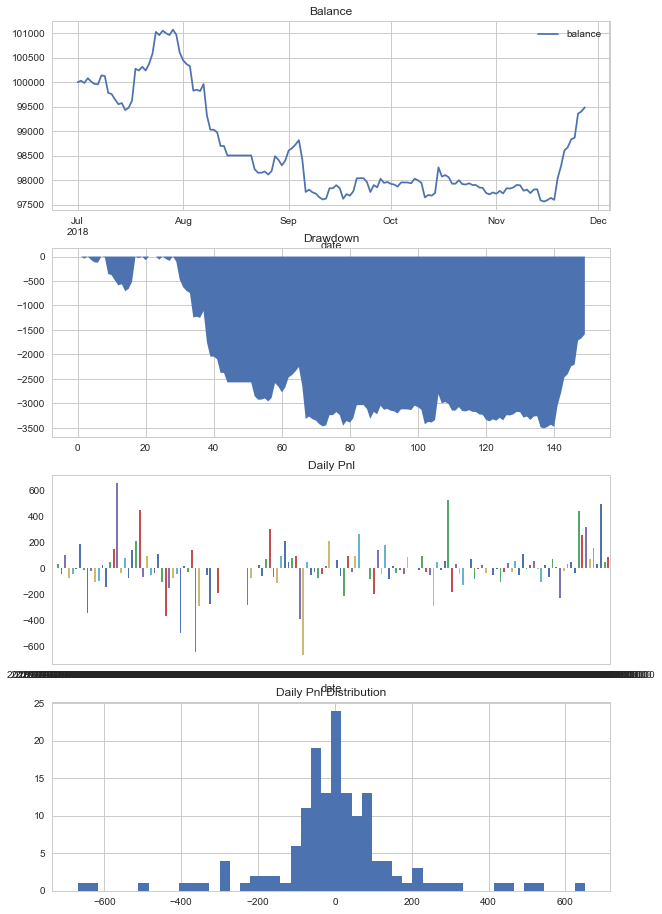

In [12]:
# 显示逐日回测结果
engine.showDailyResult()
# balance 资金
# Drawdown 回撤
# Daily pnl 日均盈亏
# 日盈亏统计 看是赚还是亏的天数多少



2018-12-09 22:14:04.619994	计算回测结果
2018-12-09 22:14:04.623995	------------------------------
2018-12-09 22:14:04.624995	第一笔交易：	2018-07-12 14:30:00
2018-12-09 22:14:04.624995	最后一笔交易：	2018-11-27 19:58:00
2018-12-09 22:14:04.624995	总交易次数：	10
2018-12-09 22:14:04.624995	总盈亏：	-516.26
2018-12-09 22:14:04.624995	最大回撤: 	-2,725.58
2018-12-09 22:14:04.624995	平均每笔盈利：	-51.63
2018-12-09 22:14:04.624995	平均每笔滑点：	0.0
2018-12-09 22:14:04.625995	平均每笔佣金：	6.19
2018-12-09 22:14:04.625995	胜率		10.0%
2018-12-09 22:14:04.625995	盈利交易平均值	2,209.32
2018-12-09 22:14:04.625995	亏损交易平均值	-302.84
2018-12-09 22:14:04.625995	盈亏比：	7.3


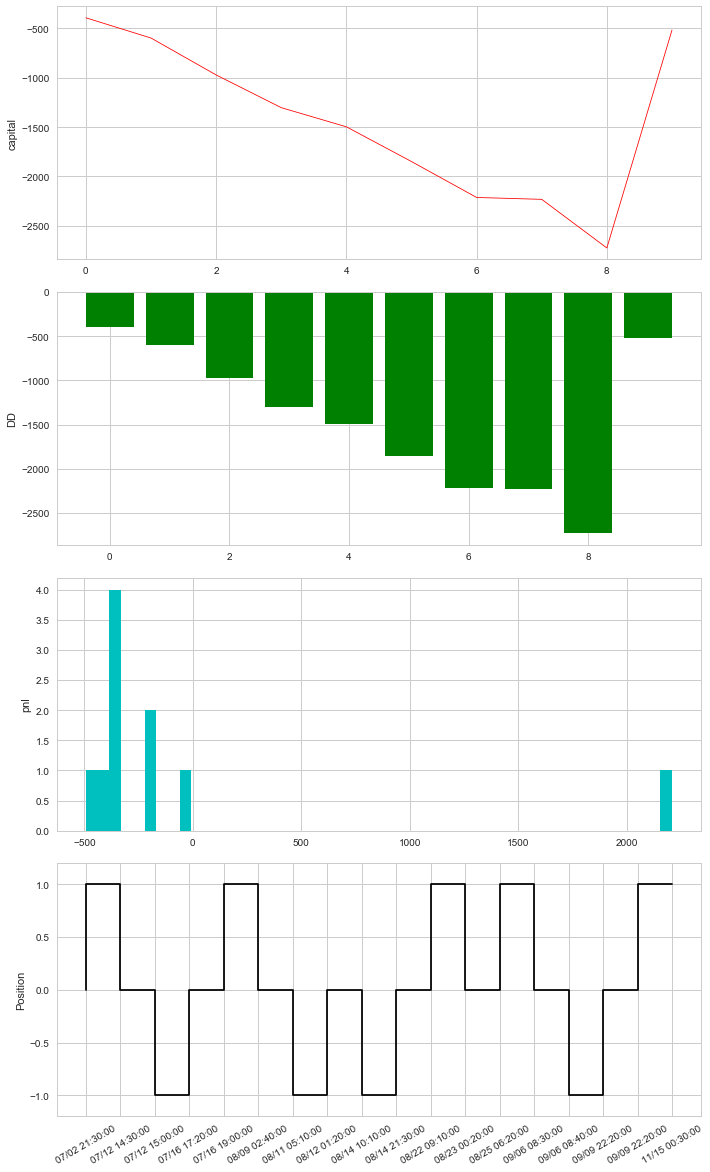

In [13]:
# 显示逐笔回测结果
engine.showBacktestingResult()
# capital list
# draw list 回撤
# pnl 每笔盈亏序列
# position 仓位